In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv(r"D:\EPL\topassist.csv")

# Drop unnecessary / end-of-season / engineered columns
drop_cols = [
    "Season", "Rank", "Player", "Club","Crosses_Completed",
     "Club_Total_Goals",                                  
     "xA_per_90", "Key_Passes_per_90", 
]

df.drop(columns=drop_cols, inplace=True)


In [4]:
# Check nulls
print("Before filling:\n", df.isnull().sum())

# Fill numeric columns with mean
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Fill categorical columns with 'Unknown'
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna("Unknown")

# Check again
print("\nAfter filling:\n", df.isnull().sum())

Before filling:
 Age                        0
Position                   0
Minutes_Played             0
Assists_prev_season      108
Goals_prev_season         88
Assists                    0
Key_Passes                 0
Expected_Assists_(xA)      0
Dribbles_Completed         0
Shots_Assisted             0
Set_Piece_Involvement      0
Club_League_Rank           0
Big6_Club_Feature          0
Club_Attack_Share          0
Club_xG                    0
Assists_per_90             0
dtype: int64

After filling:
 Age                      0
Position                 0
Minutes_Played           0
Assists_prev_season      0
Goals_prev_season        0
Assists                  0
Key_Passes               0
Expected_Assists_(xA)    0
Dribbles_Completed       0
Shots_Assisted           0
Set_Piece_Involvement    0
Club_League_Rank         0
Big6_Club_Feature        0
Club_Attack_Share        0
Club_xG                  0
Assists_per_90           0
dtype: int64


In [5]:
# Check duplicates
print("Duplicates:", df.duplicated().sum())

# Remove duplicates
df.drop_duplicates(inplace=True)

Duplicates: 0


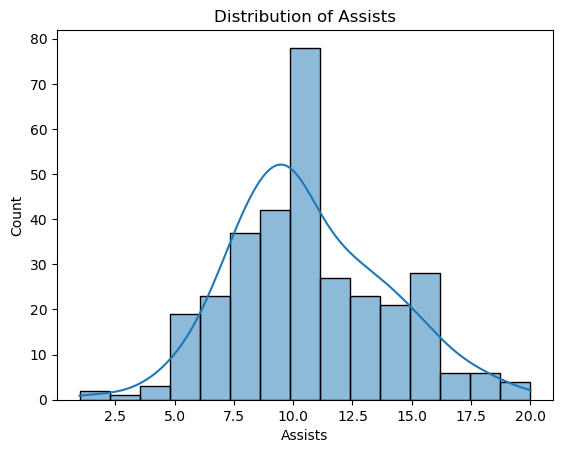

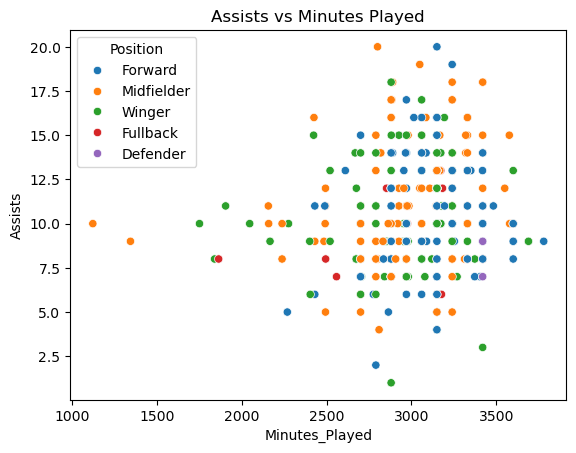

In [6]:
# Distribution of Assists
sns.histplot(df["Assists"], bins=15, kde=True)
plt.title("Distribution of Assists")
plt.show()

# Assists vs Minutes Played
sns.scatterplot(x="Minutes_Played", y="Assists", hue="Position", data=df)
plt.title("Assists vs Minutes Played")
plt.show()

In [7]:
# Example: Detect outliers in 'Assists'
Q1 = df["Assists"].quantile(0.25)
Q3 = df["Assists"].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df["Assists"] < (Q1 - 1.5 * IQR)) | (df["Assists"] > (Q3 + 1.5 * IQR))]
print("Outliers in Assists:", outliers.shape[0])

Outliers in Assists: 0


In [8]:
# Feature Engineering
df["Assists_per_90"] = df["Assists"] / (df["Minutes_Played"] / 90)
df["Goals_per_90"] = df["Goals_prev_season"] / (df["Minutes_Played"] / 90)
df["Dribbles_per_90"] = df["Dribbles_Completed"] / (df["Minutes_Played"] / 90)



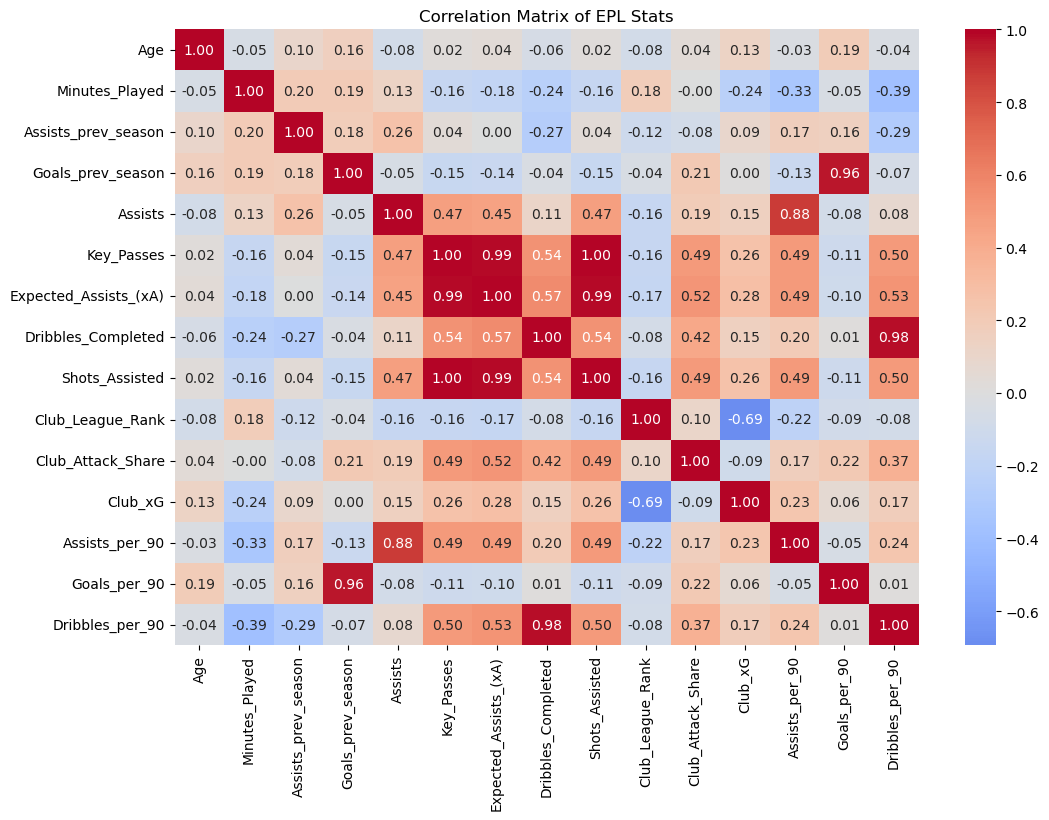

In [9]:
# Keep only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Compute correlation matrix
corr = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix of EPL Stats")
plt.show()


In [39]:
df = df.dropna(axis=1, how="all")


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import joblib

# Load data
df = pd.read_csv(r"D:\EPL\topassist.csv")

# Drop leakage columns
df = df.drop(columns=["Club_Total_Goals", "Contribution_Ratio_mid","Club_League_Rank","Season","Rank","Club","xA_per_90","Assists_per_90",], errors="ignore")

# Drop fully empty columns
df = df.dropna(axis=1, how="all")

# Feature Engineering
df["Goals_per_90"] = df["Goals_prev_season"] / (df["Minutes_Played"] / 90)
df["Assists_prev_per_90"] = df["Assists_prev_season"] / (df["Minutes_Played"] / 90)
df["Key_Passes_per_90"] = df["Key_Passes"] / (df["Minutes_Played"] / 90)
df["Dribbles_per_90"] = df["Dribbles_Completed"] / (df["Minutes_Played"] / 90)
df["Shots_Assisted_per_90"] = df["Shots_Assisted"] / (df["Minutes_Played"] / 90)
df["Minutes_Attack"] = df["Minutes_Played"] * df["Club_Attack_Share"]

# Features and target
X = df.drop(columns=["Assists", "Player"])
y = df["Assists"]

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()

# Preprocessor with imputation
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean"))
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# Model & Pipeline
rf = RandomForestRegressor(random_state=42)
pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", rf)
])

# Hyperparameter grid
param_dist = {
    "model__n_estimators": np.arange(100, 1001, 100),
    "model__max_depth": [None] + list(np.arange(10, 101, 10)),
    "model__min_samples_split": np.arange(2, 11),
    "model__min_samples_leaf": np.arange(1, 11),
    "model__max_features": ["sqrt", "log2", None]
}

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='r2'
)
random_search.fit(X_train, y_train)

# Best Model
best_pipeline = random_search.best_estimator_

# Predictions & Evaluation
y_pred = best_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mean Squared Error: 7.535643399881916
Root Mean Squared Error: 2.7451126388332256
R² Score: 0.39335700931768225


In [12]:
 #Save final pipeline
joblib.dump(best_pipeline, "topassists_pipeline.pkl")
print("Pipeline saved as topassists_pipeline.pkl")


Pipeline saved as topassists_pipeline.pkl


In [13]:
import joblib
pipeline = joblib.load("topassists_pipeline.pkl")
print(pipeline.feature_names_in_)  # For scikit-learn >=1.0

['Age' 'Position' 'Minutes_Played' 'Assists_prev_season'
 'Goals_prev_season' 'Key_Passes' 'Expected_Assists_(xA)'
 'Dribbles_Completed' 'Shots_Assisted' 'Set_Piece_Involvement'
 'Big6_Club_Feature' 'Club_Attack_Share' 'Club_xG' 'Key_Passes_per_90'
 'Goals_per_90' 'Assists_prev_per_90' 'Dribbles_per_90'
 'Shots_Assisted_per_90' 'Minutes_Attack']


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# -----------------------------
# 1️⃣ Load Data
# -----------------------------
df = pd.read_csv(r"D:\EPL\topassist.csv")

# Drop leakage or unnecessary columns
df = df.drop(columns=[
    "Club_Total_Goals", "Contribution_Ratio_mid", "Club_League_Rank",
    "Season", "Rank", "Club", "xA_per_90", "Assists_per_90"
], errors="ignore")

# Drop empty columns
df = df.dropna(axis=1, how="all")

# -----------------------------
# 2️⃣ Basic Feature Engineering
# -----------------------------
df["Goals_per_90"] = df["Goals_prev_season"] / (df["Minutes_Played"] / 90)
df["Assists_prev_per_90"] = df["Assists_prev_season"] / (df["Minutes_Played"] / 90)
df["Key_Passes_per_90"] = df["Key_Passes"] / (df["Minutes_Played"] / 90)
df["Dribbles_per_90"] = df["Dribbles_Completed"] / (df["Minutes_Played"] / 90)
df["Shots_Assisted_per_90"] = df["Shots_Assisted"] / (df["Minutes_Played"] / 90)
df["Minutes_Attack"] = df["Minutes_Played"] * df["Club_Attack_Share"]

# -----------------------------
# 3️⃣ Define Features and Target
# -----------------------------
X = df.drop(columns=["Assists", "Player"])
y = df["Assists"]

# -----------------------------
# 4️⃣ Preprocessing
# -----------------------------
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean"))
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# -----------------------------
# 5️⃣ Model Pipeline
# -----------------------------
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", rf)
])

# -----------------------------
# 6️⃣ Train-Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# 7️⃣ Train and Evaluate
# -----------------------------
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("✅ Basic Random Forest Model Results:")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")


✅ Basic Random Forest Model Results:
Mean Squared Error: 7.620
Root Mean Squared Error: 2.760
R² Score: 0.387
